<a href="https://colab.research.google.com/github/BrajanNieto/MPPT_Algorithms/blob/main/IA_Fundamentals_Evaluation_MPPT_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.special import lambertw
import math
from tqdm import tqdm


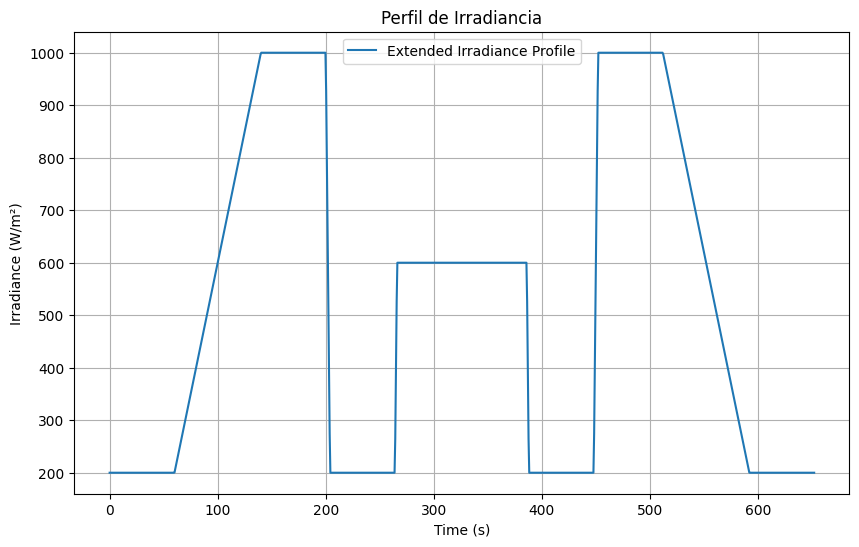

In [ ]:
def irradiance_profile(time):
    """
    Define cómo var irradiancia a lo largo del tiempo.
    """
    if time <= 60:
        return 200
    elif 60 < time <= 140:
        return 200 + 10 * (time - 60)
    elif 140 < time <= 200:
        return 1000
    elif 200 < time <= 204:
        return 1000 - 200 * (time - 200)
    elif 204 < time <= 264:
        return 200
    elif 264 < time <= 266:
        return 200 + 200 * (time - 264)
    elif 266 < time <= 386:
        return 600
    elif 386 < time <= 388:
        return 600 - 200 * (time - 386)
    elif 388 < time <= 448:
        return 200
    elif 448 < time <= 452:
        return 200 + 200* (time - 448)
    elif 452 < time <= 512:
        return 1000
    elif 512 < time <= 592:
        return 1000 - 10 * (time - 512)
    elif 592 < time <= 652:
        return 200
    else:
        return 200


time_extended = np.linspace(0, 652, 1000)
irradiance_extended = [irradiance_profile(t) for t in time_extended]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_extended, irradiance_extended, label="Extended Irradiance Profile")
plt.title("Perfil de Irradiancia")
plt.xlabel("Time (s)")
plt.ylabel("Irradiance (W/m²)")
plt.grid()
plt.legend()
plt.show()


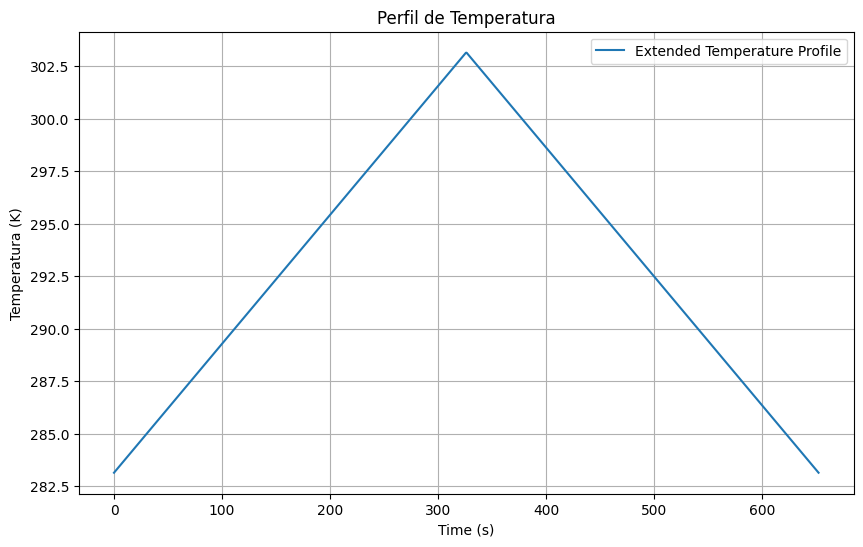

In [ ]:
def temperature_profile(time):
    """
    Define cómo varía la temperatura a lo largo del tiempo.
    """
    if time <= 326:
        # Temperatura aumenta de 25°C (298.15 K) a 35°C (308.15 K) en 326 s
        return 283.15 + (time / 326) * 20
    elif 326 < time <= 652:
        # Temperatura disminuye de 35°C (308.15 K) a 25°C (298.15 K) en 326s
        return 303.15 - ((time - 326) / 326) * 20
    else:
        return 298.15


temperature_extended = [temperature_profile(t) for t in time_extended]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_extended, temperature_extended, label="Extended Temperature Profile")
plt.title("Perfil de Temperatura")
plt.xlabel("Time (s)")
plt.ylabel("Temperatura (K)")
plt.grid()
plt.legend()
plt.show()


### Fotocorriente (Iph)

La **fotocorriente (Iph)** es la corriente generada por la luz incidente y es proporcional a la irradiancia solar (**G**) que recibe el panel.

### Cálculo típico:

La fórmula para calcular **Iph** es:

$I_{ph} = \left( I_{sc} + \alpha \cdot (T - T_{ref}) \right) \cdot \frac{G}{G_{ref}}$

### Donde:
- $ I_{sc} $: Corriente de cortocircuito del panel solar.
- $ \alpha $: Coeficiente de temperatura de la corriente ($ \text{A/°C} $).
- $ T $: Temperatura de operación del panel ($ \text{°C} $).
- $ T_{ref} $: Temperatura de referencia ($ \text{°C} $).
- $ G $: Irradiancia solar actual ($ \text{W/m}^2 $).
- $ G_{ref} $: Irradiancia solar de referencia ($ \text{W/m}^2 $).


In [ ]:
# Parámetros del panel solar
I_sc_ref = 8.5        # Corriente de cortocircuito a condiciones estándar (A)
alpha_Isc = 0.0005    # Coeficiente de temperatura de I_sc (A/K)
T_ref = 298.15        # Temperatura de referencia (25°C en Kelvin)
G_ref = 1000          # Irradiancia solar de referencia. (W/m2)

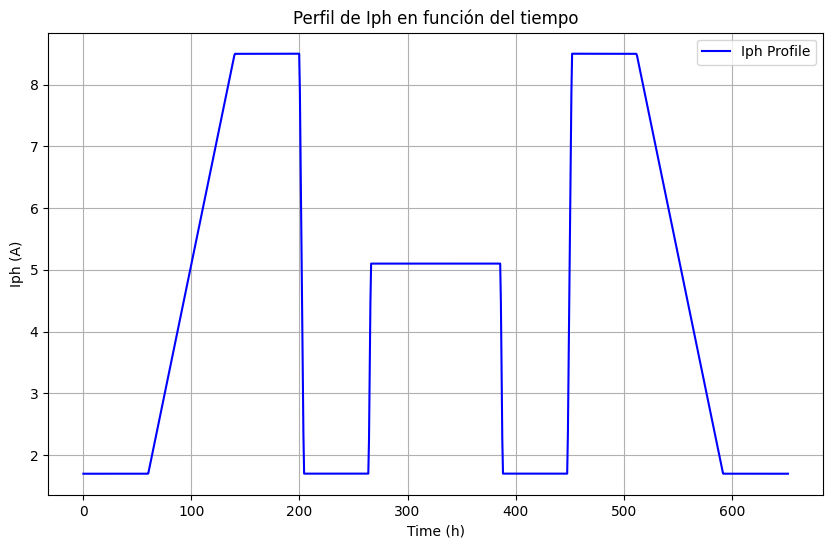

In [ ]:
# Definimos la función para calcular Iph
def calculate_Iph(time, I_sc_ref, alpha_Isc, T_ref, G_ref):
    """
    Calcula la fotocorriente (Iph) en función del tiempo.

    Parámetros:
        time (float): Tiempo en el cual se calcula Iph.
        I_sc_ref (float): Corriente de cortocircuito bajo condiciones estándar (A).
        alpha_Isc (float): Coeficiente de temperatura para Isc (en A/K).
        T_ref (float): Temperatura de referencia en Kelvin.
        G_ref (float): Irradiancia solar de referencia (en W/m^2).

    Retorna:
        float: Valor de Iph en el tiempo dado.
    """
    # Obtener valores de temperatura y irradiancia del perfil
    T = temperature_profile(time)  # Temperatura en Kelvin
    G = irradiance_profile(time)   # Irradiancia en W/m^2

    # Calcular Iph según la fórmula
    Iph = (I_sc_ref + alpha_Isc * (T - T_ref)) * (G / G_ref)
    return Iph

# Graficar el perfil de Iph
Iph_extended = [calculate_Iph(t, I_sc_ref, alpha_Isc, T_ref, G_ref) for t in time_extended]

plt.figure(figsize=(10, 6))
plt.plot(time_extended, Iph_extended, label="Iph Profile", color='blue')
plt.title("Perfil de Iph en función del tiempo")
plt.xlabel("Time (h)")
plt.ylabel("Iph (A)")
plt.grid()
plt.legend()
plt.show()

## Corriente de saturación inversa del diodo ($ I_0 $)

La corriente de saturación inversa del diodo, $ I_0 $, se calcula con la siguiente fórmula:

$
I_0 = I_{sc\_ref} \cdot \left( \frac{T}{T_{ref}} \right)^3 \cdot e^{-\frac{E_g \cdot q}{k \cdot T}}
$

### Parámetros
- $ I_{sc\_ref} $: Corriente de cortocircuito bajo condiciones estándar (A).
- $T $: Temperatura en Kelvin en el tiempo actual ($ time$).
- $T_{ref} $: Temperatura de referencia en Kelvin.
- $ E_g $: Energía de la banda prohibida del material semiconductor (eV).
- $ q $: Carga del electrón ($ 1.602 \times 10^{-19} \, C $).
- $ k $: Constante de Boltzmann ($ 1.38 \times 10^{-23} \, J/K $).



In [ ]:
# Constantes físicas
k = 1.380649e-23     # Constante de Boltzmann (J/K)
q = 1.602176634e-19  # Carga del electrón (C)
# Parámetros del panel solar
V_oc_ref = 22.0       # Voltaje de circuito abierto a condiciones estándar (V)
n = 1.3               # Factor de idealidad del diodo
E_g = 1.1            # Energía de la banda prohibida (eV)
# Determinar número de celdas en serie
V_oc_cell = 0.611        # Voltaje de circuito abierto por celda (V)
N_s = int(V_oc_ref / V_oc_cell)
print(f"Número de celdas en serie: {N_s}")
# Parámetros por celda
I_sc_ref_cell = I_sc_ref  # Corriente de cortocircuito por celda (A)
V_oc_ref_cell = V_oc_ref / N_s  # Voltaje de circuito abierto por celda (V)
R_s_cell = R_s / N_s            # Resistencia serie por celda (Ω)
R_sh_cell = R_sh * N_s          # Resistencia shunt por celda (Ω)

Número de celdas en serie: 36


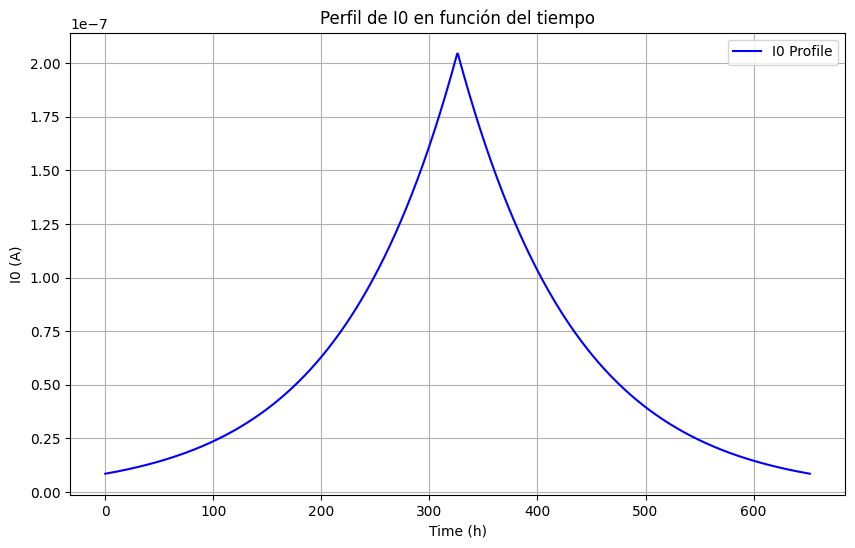

In [ ]:
def calculate_I0(time, I_sc_ref_cell, V_oc_ref_cell, n, T_ref, E_g, k, q):
    T = temperature_profile(time)
    E_g_J = E_g * q
    V_t_ref = k * T_ref / q
    exponent_ref = q * V_oc_ref_cell / (n * k * T_ref)
    if exponent_ref > 100:
        I0_ref = I_sc_ref_cell * math.exp(-exponent_ref)
    else:
        I0_ref = I_sc_ref_cell / (math.exp(exponent_ref) - 1)
    delta_T_inv = (1 / T) - (1 / T_ref)
    exponent = -E_g_J / k * delta_T_inv
    I0 = I0_ref * (T / T_ref)**3 * math.exp(exponent)
    return I0

# Graficar el perfil de I0
I0_extended = [calculate_I0 (t, I_sc_ref_cell, V_oc_ref_cell, n, T_ref, E_g, k, q) for t in time_extended]
plt.figure(figsize=(10, 6))
plt.plot(time_extended, I0_extended, label="I0 Profile", color='blue')
plt.title("Perfil de I0 en función del tiempo")
plt.xlabel("Time (h)")
plt.ylabel("I0 (A)")
plt.grid()
plt.legend()
plt.show()

### Modelo de 1 diodo

El modelo de un diodo para un panel solar se describe mediante la siguiente fórmula:

$I = I_{ph} - I_0 \cdot \left( e^{\frac{q \cdot (V + I \cdot R_s)}{n \cdot k \cdot T}} - 1 \right) - \frac{V + I \cdot R_s}{R_{sh}}$

### Donde:
- $I$: Corriente de salida del panel solar (A).
- $I_{ph}$: Fotocorriente generada por la luz incidente (A).
- $I_0$: Corriente de saturación inversa del diodo (A).
- $q$: Carga del electrón ($1.602 \times 10^{-19} \, C$).
- $V$: Voltaje en los terminales del panel solar (V).
- $R_s$: Resistencia en serie del panel solar ($\Omega$).
- $R_{sh}$: Resistencia en paralelo (o shunt) del panel solar ($\Omega$).
- $n$: Factor de idealidad del diodo (típicamente entre 1 y 2).
- $k$: Constante de Boltzmann ($1.381 \times 10^{-23} \, J/K$).
- $T$: Temperatura absoluta del panel (K).

In [ ]:
# Parámetros del panel solar (ejemplo)
R_s = 0.1             # Resistencia serie (Ω)
R_sh = 1000.0         # Resistencia paralela (Ω)

In [ ]:
def current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k, q):
    I_ph = calculate_Iph(time, I_sc_ref, alpha_Isc, T_ref, G_ref)
    I_0 = calculate_I0(time, I_sc_ref, V_oc_ref, n, T_ref, E_g, k, q)
    T = temperature_profile(time)
    V_t = k * T / q

    # Definir la ecuación implícita a resolver
    def diode_equation(I):
        exponent = (V + I * R_s) / (n * V_t)
        # Controlar el exponente para evitar OverflowError
        if exponent > 700:
            exp_term = np.exp(700)
        else:
            exp_term = np.exp(exponent)
        return I_ph - I_0 * (exp_term - 1) - (V + I * R_s) / R_sh - I

    # Usar fsolve para resolver la ecuación
    I_initial_guess = I_ph  # Aproximación inicial
    I_solution, info, ier, mesg = fsolve(diode_equation, I_initial_guess, full_output=True)
    if ier != 1:
        print(f"Solución no encontrada en V={V}, tiempo={time}: {mesg}")
        I_solution = [np.nan]  # Asignar NaN si no converge
    return I_solution[0]

Solución no encontrada en V=23.149549549549548, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.175975975975973, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.202402402402402, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.228828828828828, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.255255255255253, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.28168168168168, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

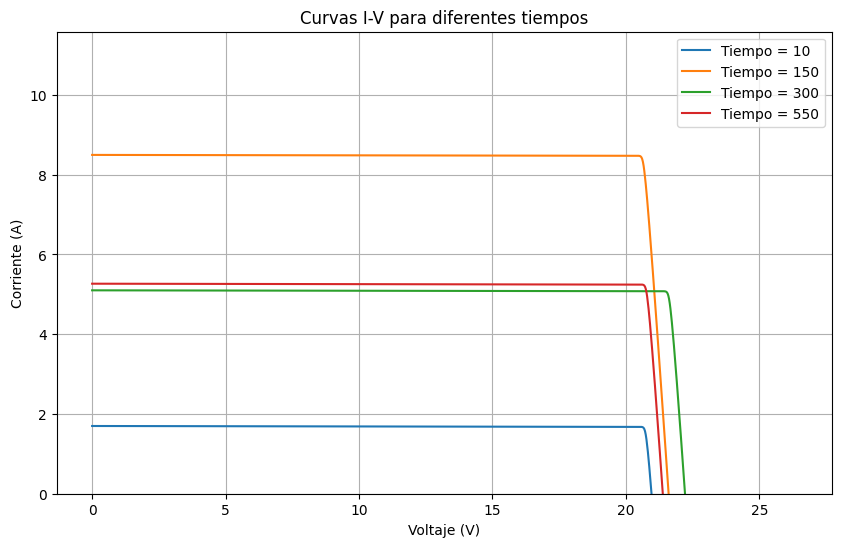

In [ ]:
# Tiempos específicos
times = [10, 150, 300, 550]  # Puedes ajustar estos valores

# Rango de voltajes
V_values = np.linspace(0, V_oc_ref * 1.2, 1000)  # 100 puntos entre 0 V y V_oc_ref

# Graficar las curvas I-V para cada tiempo
plt.figure(figsize=(10, 6))
for time in times:
    I_values = []
    for V in V_values:
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                 T_ref, G_ref, E_g, R_s, R_sh, k, q)
        I_values.append(I)
    plt.plot(V_values, I_values, label=f'Tiempo = {time}')

# Limitar el eje Y a valores no negativos
plt.ylim(0, None)

# Personalizar etiquetas y leyenda
plt.title('Curvas I-V para diferentes tiempos')
plt.xlabel('Voltaje (V)')
plt.ylabel('Corriente (A)')
plt.legend()
plt.grid(True)
plt.show()

Solución no encontrada en V=23.149549549549548, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.175975975975973, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.202402402402402, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.228828828828828, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.255255255255253, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.28168168168168, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

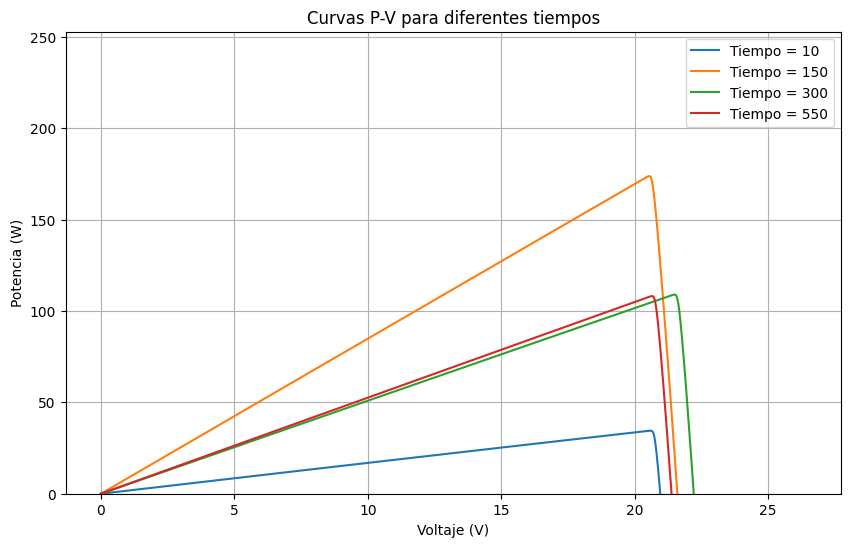

In [ ]:
# Tiempos específicos
times = [10, 150, 300, 550]  # Puedes ajustar estos valores

# Rango de voltajes
V_values = np.linspace(0, V_oc_ref * 1.2, 1000)  # 1000 puntos entre 0 V y V_oc_ref

# Graficar las curvas P-V para cada tiempo
plt.figure(figsize=(10, 6))
for time in times:
    P_values = []
    for V in V_values:
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                 T_ref, G_ref, E_g, R_s, R_sh, k, q)
        P = V * I  # Potencia
        P_values.append(P)
    plt.plot(V_values, P_values, label=f'Tiempo = {time}')

# Limitar el eje Y a valores no negativos
plt.ylim(0, None)

# Personalizar etiquetas y leyenda
plt.title('Curvas P-V para diferentes tiempos')
plt.xlabel('Voltaje (V)')
plt.ylabel('Potencia (W)')
plt.legend()
plt.grid(True)
plt.show()

Solución no encontrada en V=23.149549549549548, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.175975975975973, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.202402402402402, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.228828828828828, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.255255255255253, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.28168168168168, tiempo=300: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

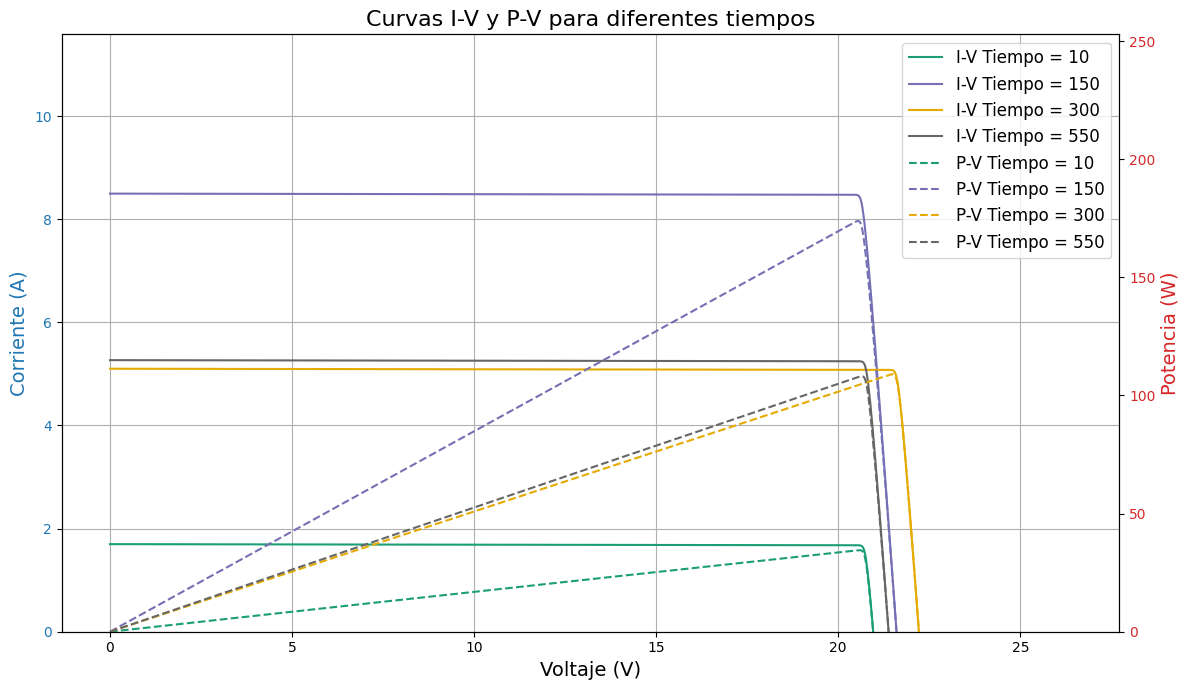

In [ ]:

# Tiempos específicos
times = [10, 150, 300, 550]  # Puedes ajustar estos valores

# Rango de voltajes
V_values = np.linspace(0, V_oc_ref * 1.2, 1000)  # 1000 puntos entre 0 V y 1.2 * V_oc_ref

# Crear la figura y el eje principal
fig, ax1 = plt.subplots(figsize=(12, 7))

# Colores para diferentes tiempos
colors = plt.cm.Dark2(np.linspace(0, 1, len(times)))

# Graficar las curvas I-V para cada tiempo en el eje principal
for idx, time in enumerate(times):
    I_values = []
    for V in V_values:
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                T_ref, G_ref, E_g, R_s, R_sh, k, q)
        I_values.append(I)
    ax1.plot(V_values, I_values, label=f'I-V Tiempo = {time}', color=colors[idx], linestyle='-')

# Configurar el eje Y principal (Corriente)
ax1.set_xlabel('Voltaje (V)', fontsize=14)
ax1.set_ylabel('Corriente (A)', fontsize=14, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, None)  # Limitar a valores no negativos

# Crear el eje secundario para la Potencia
ax2 = ax1.twinx()

# Graficar las curvas P-V para cada tiempo en el eje secundario
for idx, time in enumerate(times):
    P_values = []
    for V in V_values:
        I = current_single_diode(V, time, I_sc_ref, alpha_Isc, V_oc_ref, n,
                                T_ref, G_ref, E_g, R_s, R_sh, k, q)
        P = V * I  # Potencia
        P_values.append(P)
    ax2.plot(V_values, P_values, label=f'P-V Tiempo = {time}', color=colors[idx], linestyle='--')

# Configurar el eje Y secundario (Potencia)
ax2.set_ylabel('Potencia (W)', fontsize=14, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, None)  # Limitar a valores no negativos

# Título y leyendas
plt.title('Curvas I-V y P-V para diferentes tiempos', fontsize=16)

# Manejar las leyendas para ambos ejes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=12)

# Añadir una cuadrícula
ax1.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [ ]:
# Rango de tiempo (segundos)
time_start = 1
time_end = 652
time_steps = np.arange(time_start, time_end + 1)  # Incluye el tiempo_end

Procesando tiempos:   2%|▏         | 12/652 [00:00<00:18, 34.48it/s]

Solución no encontrada en V=26.4, tiempo=3: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=5: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=9: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=11: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=12: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:   3%|▎         | 20/652 [00:00<00:18, 34.09it/s]

Solución no encontrada en V=26.4, tiempo=13: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=16: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=17: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=18: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=21: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:   4%|▍         | 28/652 [00:00<00:18, 33.98it/s]

Solución no encontrada en V=26.4, tiempo=23: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  32%|███▏      | 206/652 [00:08<00:14, 31.84it/s]

Solución no encontrada en V=22.933333333333334, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.2, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=203: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en 

Procesando tiempos:  34%|███▎      | 219/652 [00:08<00:12, 34.51it/s]

Solución no encontrada en V=24.53333333333333, tiempo=211: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=211: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.066666666666666, tiempo=211: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.333333333333332, tiempo=211: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.6, tiempo=211: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.866666666666667, tiempo=211: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  35%|███▍      | 227/652 [00:08<00:12, 33.35it/s]

Solución no encontrada en V=23.2, tiempo=220: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=220: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=220: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=220: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=220: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=220: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  36%|███▌      | 235/652 [00:09<00:12, 34.00it/s]

Solución no encontrada en V=23.2, tiempo=228: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=228: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=228: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=228: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=228: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=228: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  37%|███▋      | 243/652 [00:09<00:12, 32.83it/s]

Solución no encontrada en V=23.2, tiempo=236: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=236: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=236: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=236: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=236: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=236: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  38%|███▊      | 247/652 [00:09<00:12, 31.84it/s]

Solución no encontrada en V=23.466666666666665, tiempo=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=244: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  40%|███▉      | 259/652 [00:09<00:11, 33.38it/s]

Solución no encontrada en V=23.466666666666665, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=252: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  41%|████      | 267/652 [00:10<00:11, 34.16it/s]

Solución no encontrada en V=25.333333333333332, tiempo=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.6, tiempo=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.866666666666667, tiempo=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.133333333333333, tiempo=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=261: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=262: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en 

Procesando tiempos:  43%|████▎     | 279/652 [00:10<00:11, 32.88it/s]

Solución no encontrada en V=23.2, tiempo=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=270: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  44%|████▍     | 287/652 [00:10<00:11, 31.12it/s]

Solución no encontrada en V=23.2, tiempo=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=280: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  45%|████▌     | 295/652 [00:11<00:11, 31.84it/s]

Solución no encontrada en V=26.4, tiempo=290: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.2, tiempo=291: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=291: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=291: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=291: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=291: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.533333333

Procesando tiempos:  46%|████▋     | 303/652 [00:11<00:10, 32.63it/s]

Solución no encontrada en V=24.0, tiempo=298: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=298: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=298: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=298: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.066666666666666, tiempo=298: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.333333333333332, tiempo=298: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  48%|████▊     | 311/652 [00:11<00:10, 32.09it/s]

Solución no encontrada en V=23.2, tiempo=305: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=305: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=305: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=305: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=305: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=305: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  49%|████▉     | 319/652 [00:11<00:10, 32.23it/s]

Solución no encontrada en V=23.2, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=313: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  50%|█████     | 327/652 [00:12<00:10, 32.49it/s]

Solución no encontrada en V=23.466666666666665, tiempo=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=320: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  51%|█████▏    | 335/652 [00:12<00:09, 33.65it/s]

Solución no encontrada en V=23.466666666666665, tiempo=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=328: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  53%|█████▎    | 343/652 [00:12<00:09, 32.50it/s]

Solución no encontrada en V=23.466666666666665, tiempo=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=336: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  55%|█████▍    | 356/652 [00:12<00:08, 33.63it/s]

Solución no encontrada en V=25.6, tiempo=346: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.866666666666667, tiempo=346: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.133333333333333, tiempo=346: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=346: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.2, tiempo=347: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=347: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333

Procesando tiempos:  55%|█████▌    | 360/652 [00:13<00:08, 32.60it/s]

Solución no encontrada en V=23.2, tiempo=357: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=357: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=357: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=357: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=357: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=357: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  56%|█████▋    | 368/652 [00:13<00:09, 30.94it/s]

Solución no encontrada en V=23.733333333333334, tiempo=364: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=364: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=364: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=364: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=364: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.066666666666666, tiempo=364: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  58%|█████▊    | 376/652 [00:13<00:09, 29.78it/s]

Solución no encontrada en V=23.2, tiempo=371: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=371: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=371: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=371: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=371: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=371: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  59%|█████▉    | 384/652 [00:13<00:08, 30.51it/s]

Solución no encontrada en V=23.2, tiempo=377: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=377: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=377: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=377: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=377: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=377: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  60%|██████    | 392/652 [00:14<00:08, 31.99it/s]

Solución no encontrada en V=23.2, tiempo=387: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=387: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=387: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=387: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=387: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=387: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  61%|██████▏   | 400/652 [00:14<00:07, 31.98it/s]

Solución no encontrada en V=23.466666666666665, tiempo=393: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=393: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=393: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=393: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=393: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=393: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  62%|██████▏   | 404/652 [00:14<00:08, 30.48it/s]

Solución no encontrada en V=23.466666666666665, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=401: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  63%|██████▎   | 408/652 [00:14<00:09, 27.00it/s]

Solución no encontrada en V=23.466666666666665, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=407: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  63%|██████▎   | 414/652 [00:15<00:09, 24.76it/s]

Solución no encontrada en V=23.2, tiempo=411: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=411: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=411: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=411: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=411: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=411: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  64%|██████▍   | 420/652 [00:15<00:09, 24.14it/s]

Solución no encontrada en V=23.2, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=416: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  65%|██████▍   | 423/652 [00:15<00:10, 22.44it/s]

Solución no encontrada en V=23.2, tiempo=421: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=421: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=421: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=421: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=421: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=421: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  66%|██████▌   | 429/652 [00:15<00:10, 21.74it/s]


Solución no encontrada en V=24.53333333333333, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.066666666666666, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.333333333333332, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.6, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=25.866666666666667, tiempo=425: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en 

Procesando tiempos:  66%|██████▋   | 432/652 [00:15<00:10, 21.51it/s]

Solución no encontrada en V=23.2, tiempo=430: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=430: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=430: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=430: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=430: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=430: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  67%|██████▋   | 438/652 [00:16<00:09, 23.35it/s]

Solución no encontrada en V=23.2, tiempo=435: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=435: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=435: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=435: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=435: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=435: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  68%|██████▊   | 444/652 [00:16<00:08, 23.28it/s]


Solución no encontrada en V=23.466666666666665, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.8, tiempo=440: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en 

Procesando tiempos:  69%|██████▊   | 447/652 [00:16<00:08, 24.00it/s]

Solución no encontrada en V=23.2, tiempo=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.466666666666665, tiempo=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=23.733333333333334, tiempo=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.0, tiempo=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.266666666666666, tiempo=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=24.53333333333333, tiempo=445: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V

Procesando tiempos:  98%|█████████▊| 636/652 [00:23<00:00, 33.77it/s]

Solución no encontrada en V=26.4, tiempo=629: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=631: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=634: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=635: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=636: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos:  99%|█████████▉| 648/652 [00:23<00:00, 31.97it/s]

Solución no encontrada en V=26.4, tiempo=639: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=640: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=641: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=643: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Solución no encontrada en V=26.4, tiempo=647: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Procesando tiempos: 100%|██████████| 652/652 [00:23<00:00, 27.55it/s]


Solución no encontrada en V=26.4, tiempo=652: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
   Tiempo (s)   Pmax (W)
0           1  34.419236
1           2  34.423234
2           3  34.426758
3           4  34.429868
4           5  34.432614


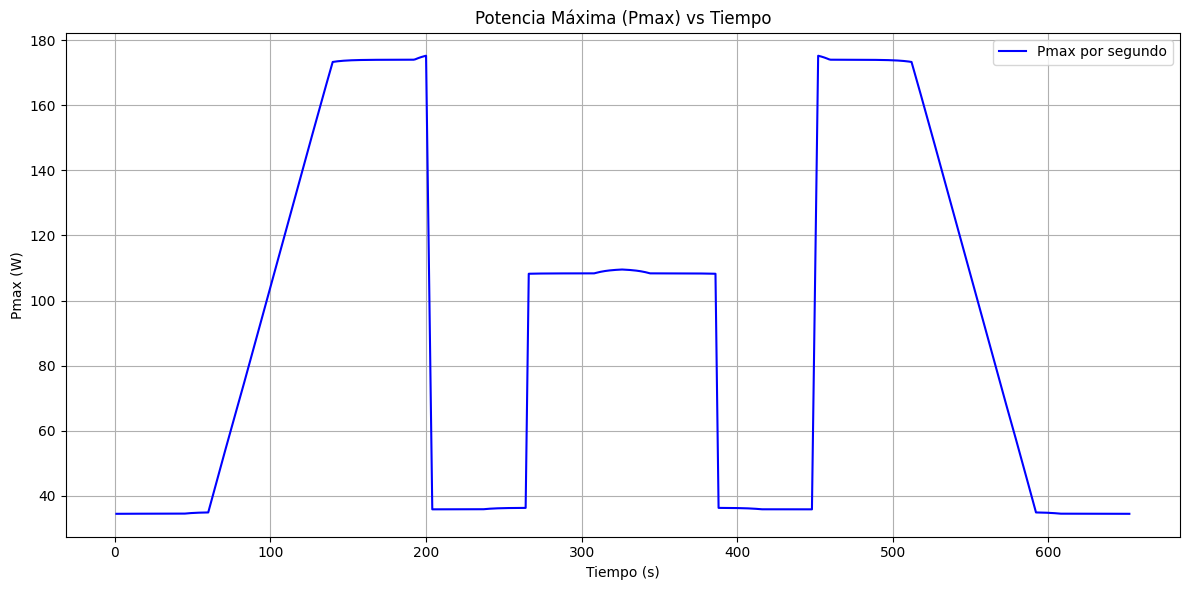

In [ ]:
# Lista para almacenar Pmax y tiempos correspondientes
pmax_list = []
time_list = []

# Voltaje máximo para cada tiempo
V_max_multiplier = 1.2  # Multiplicador para V_oc_ref

# Número de puntos de voltaje (puedes ajustarlo según la precisión requerida)
V_points = 100

# Iterar sobre cada segundo
for current_time in tqdm(time_steps, desc="Procesando tiempos"):
    # Definir rango de voltaje para este tiempo
    V_oc_current = V_oc_ref  # Asumiendo que V_oc_ref es constante; ajusta si es variable
    V_max = V_max_multiplier * V_oc_current
    V_range = np.linspace(0, V_max, V_points)

    # Listas para almacenar V, I y P para este tiempo
    I_values = []
    P_values = []

    # Iterar sobre cada voltaje
    for V in V_range:
        I = current_single_diode(V, current_time, I_sc_ref, alpha_Isc, V_oc_ref, n, T_ref, G_ref, E_g, R_s, R_sh, k,q)
        if np.isnan(I):
            P = 0  # Asignar 0 potencia si la corriente no se encontró
        else:
            P = V * I
        I_values.append(I)
        P_values.append(P)

    # Encontrar Pmax y el índice correspondiente
    P_values = np.array(P_values)
    if np.all(np.isnan(P_values)):
        P_max = np.nan
    else:
        P_max = np.nanmax(P_values)  # Usa np.nanmax para ignorar NaNs

    # Almacenar los resultados
    pmax_list.append(P_max)
    time_list.append(current_time)

# Crear un DataFrame con los resultados
df_pmax = pd.DataFrame({
    'Tiempo (s)': time_list,
    'Pmax (W)': pmax_list
})

# Mostrar las primeras filas del DataFrame
print(df_pmax.head())

# Guardar los resultados en un archivo CSV (opcional)
# df_pmax.to_csv('pmax_vs_time.csv', index=False)

# Graficar Pmax vs Tiempo
plt.figure(figsize=(12, 6))
plt.plot(df_pmax['Tiempo (s)'], df_pmax['Pmax (W)'], color='blue', label='Pmax por segundo')
plt.title('Potencia Máxima (Pmax) vs Tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Pmax (W)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

     Tiempo (s)   Pmax (W)  Irradiancia  Relación Irradiancia/Pmax
0             1  34.419236          200                   5.810704
1             2  34.423234          200                   5.810029
2             3  34.426758          200                   5.809435
3             4  34.429868          200                   5.808910
4             5  34.432614          200                   5.808447
..          ...        ...          ...                        ...
647         648  34.429868          200                   5.808910
648         649  34.426758          200                   5.809435
649         650  34.423234          200                   5.810029
650         651  34.419236          200                   5.810704
651         652  34.414701          200                   5.811470

[652 rows x 4 columns]


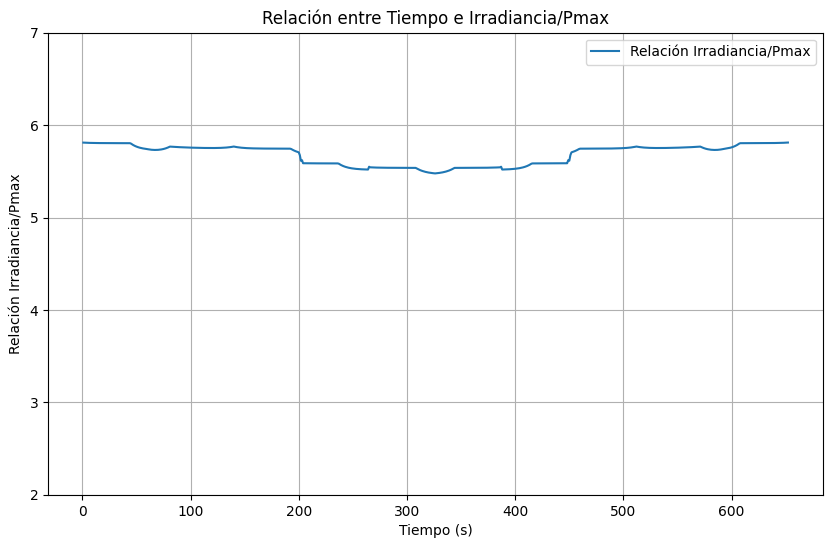

In [ ]:
# Añadir columna de Irradiancia usando la función
df_pmax['Irradiancia'] = df_pmax['Tiempo (s)'].apply(irradiance_profile)

# Añadir columna de relación entre Irradiancia y Pmax
df_pmax['Relación Irradiancia/Pmax'] = df_pmax['Irradiancia'] / df_pmax['Pmax (W)']

# Mostrar el DataFrame resultante
print(df_pmax)
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(df_pmax['Tiempo (s)'], df_pmax['Relación Irradiancia/Pmax'], linestyle='-', label='Relación Irradiancia/Pmax')
plt.title('Relación entre Tiempo e Irradiancia/Pmax')
plt.xlabel('Tiempo (s)')
plt.ylabel('Relación Irradiancia/Pmax')
plt.ylim(2, 7)  # Escalar el eje Y entre 2 y 7
plt.grid()
plt.legend()
plt.show()

# Implementación de algoritmos